# Audio Feature Extraction

In [2]:
import librosa
import librosa.display
import IPython as ipd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
# load an mp3 file

mp3_file = '/Users/gioelepozzi/Desktop/data/chorus/4.mp3'
x,sr = librosa.load(mp3_file)
ipd.display.Audio(mp3_file)

/Users/gioelepozzi/miniconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Audio Sampling Rate: 22050 samples/s
Total Samples: 618048
Audio Length: 28.02938775510204 s


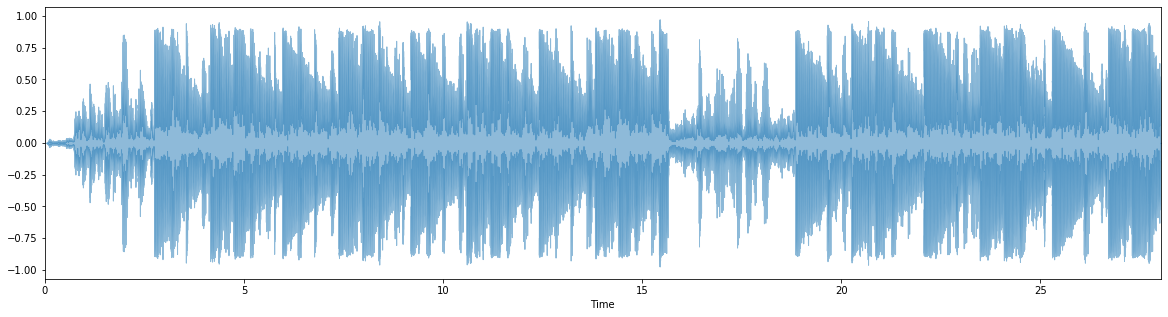

In [4]:
# audio specs

def audio_specs(audio):
    print('Audio Sampling Rate: ' + str(sr) + ' samples/s')
    print('Total Samples: ' + str(np.size(audio)))
    secs = np.size(audio)/sr
    print('Audio Length: ' + str(secs) + ' s')
    plt.figure(figsize=(20, 5))
    librosa.display.waveplot(audio, sr=sr, alpha=0.5)
    
audio_specs(x)

### Tempo estimation

In [5]:
def tempo(audio):
    onset_env = librosa.onset.onset_strength(audio, sr=sr)
    tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
    return tempo[0]

print('tempo:', tempo(x), 'bpm')

tempo: 151.99908088235293 bpm


### Beat track estimation

The output of the beat tracker is an estimate of the tempo (in beats per minute), and an array of frame numbers corresponding to detected beat events.
Frames here correspond to short windows of the signal, each separated by hop_length samples.

Beats are detected in three stages:
1. Measure onset strength
2. Estimate tempo from onset correlation
3. Pick peaks in onset strength approximately consistent with estimated tempo

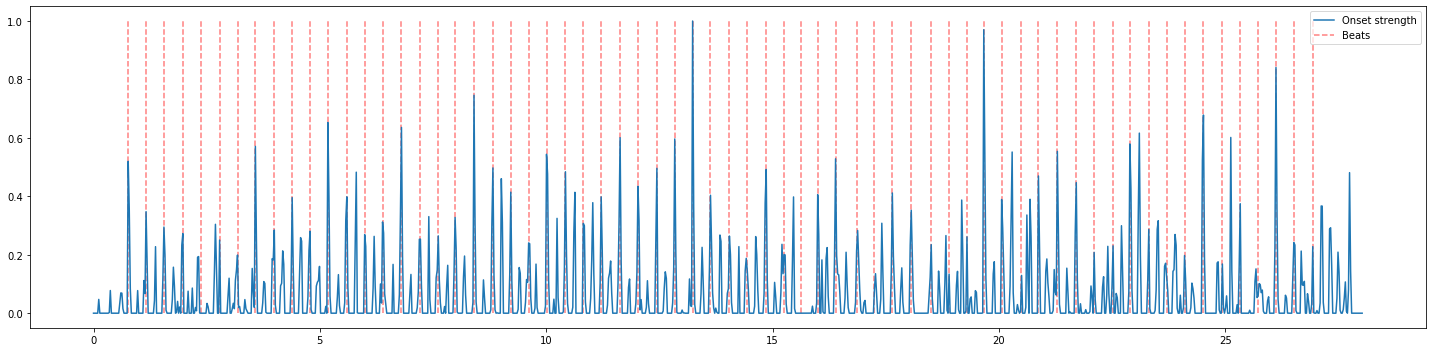

beats: [  33   50   67   85  102  120  137  154  172  189  206  223  241  258
  275  293  311  328  344  362  380  397  414  431  449  466  483  501
  518  536  553  570  587  605  622  640  657  673  689  706  726  743
  760  778  797  814  831  847  864  882  899  917  935  952  970  986
 1004 1021 1038 1056 1074 1091 1108 1125 1142 1160]


In [6]:
def beat_track(audio, hop_length):
    tempo, beats = librosa.beat.beat_track(y=audio, sr=sr)

    onset_env = librosa.onset.onset_strength(audio, sr=sr, aggregate=np.median)
    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    plt.figure(figsize=(20, 5))
    times = librosa.times_like(onset_env, sr=sr, hop_length=hop_length)
    plt.plot(times, librosa.util.normalize(onset_env),label='Onset strength')
    plt.vlines(times[beats], 0, 1, alpha=0.5, color='r',linestyle='--', label='Beats')
    plt.legend(frameon=True, framealpha=0.75)

    plt.gca().xaxis.set_major_formatter(librosa.display.TimeFormatter())
    plt.tight_layout()
    plt.show()
    
    return beats


print('beats:', beat_track(x, hop_length=512))

### Chroma stft, cqt, cens

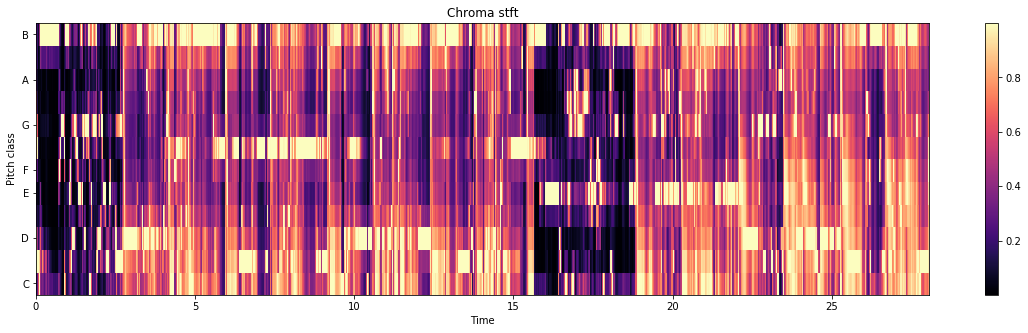

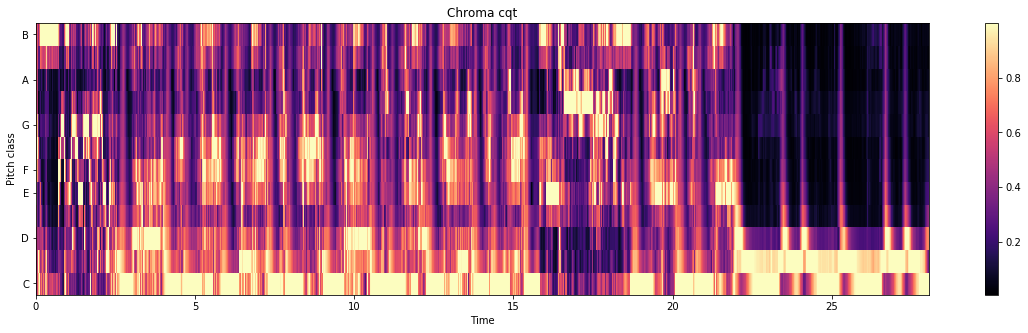

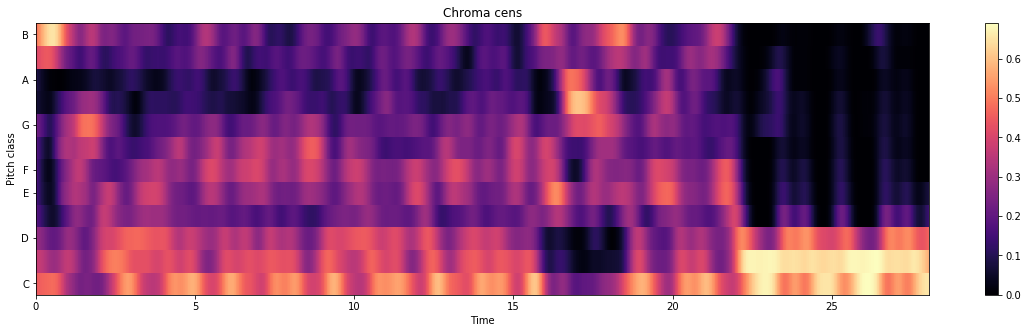

In [8]:
def chroma(audio):
    chroma_stft = librosa.feature.chroma_stft(y=audio, sr=sr)
    plt.figure(figsize=(20, 5))
    plt.title('Chroma stft')
    librosa.display.specshow(chroma_stft,y_axis='chroma', x_axis='time')
    plt.colorbar()

    chroma_cqt = librosa.feature.chroma_cqt(y=audio, sr=sr)
    plt.figure(figsize=(20, 5))
    plt.title('Chroma cqt')
    librosa.display.specshow(chroma_cqt, y_axis='chroma', x_axis='time')
    plt.colorbar()

    chroma_cens = librosa.feature.chroma_cens(y=audio, sr=sr)
    plt.figure(figsize=(20, 5))
    plt.title('Chroma cens')
    librosa.display.specshow(chroma_cens,y_axis='chroma', x_axis='time')
    plt.colorbar()
    
chroma(x)

### Melspectrogram

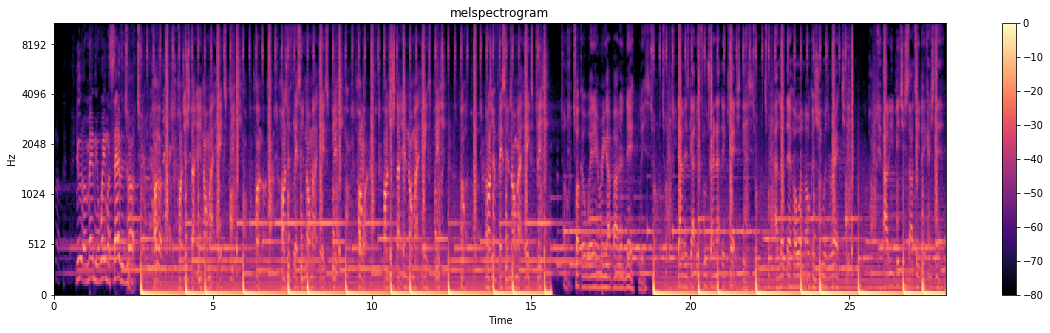

In [9]:
def melspec(audio):
    melspec = librosa.feature.melspectrogram(y=audio, sr=sr)
    plt.figure(figsize=(20, 5))
    plt.title('melspectrogram')
    librosa.display.specshow(librosa.power_to_db(melspec,ref=np.max),x_axis='time', y_axis='mel')
    plt.colorbar()

melspec(x)

### Spectral Centroid

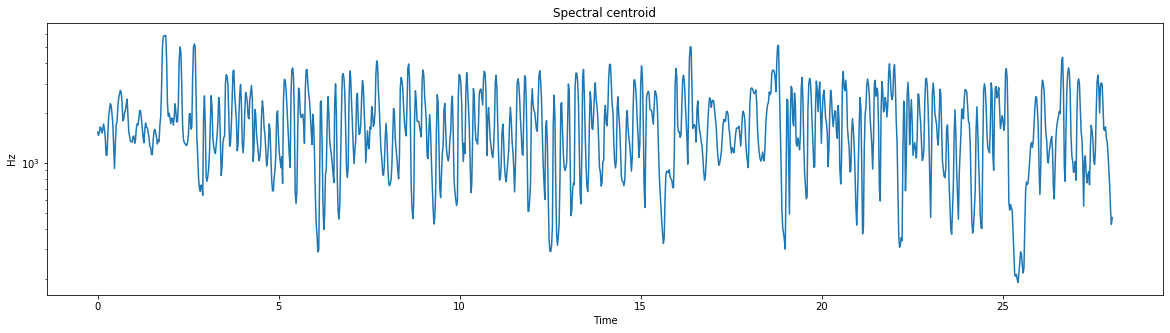

In [17]:
def spectral_centroid(audio):
    cent = librosa.feature.spectral_centroid(y=audio, sr=sr)[0]
    frames = range(len(cent))
    t = librosa.frames_to_time(frames)

    plt.figure(figsize=(20,5))
    plt.semilogy(t, cent.T)
    plt.title('Spectral centroid')
    plt.ylabel('Hz')
    plt.xlabel('Time')

spectral_centroid(x)

### Spectral Bandwidth

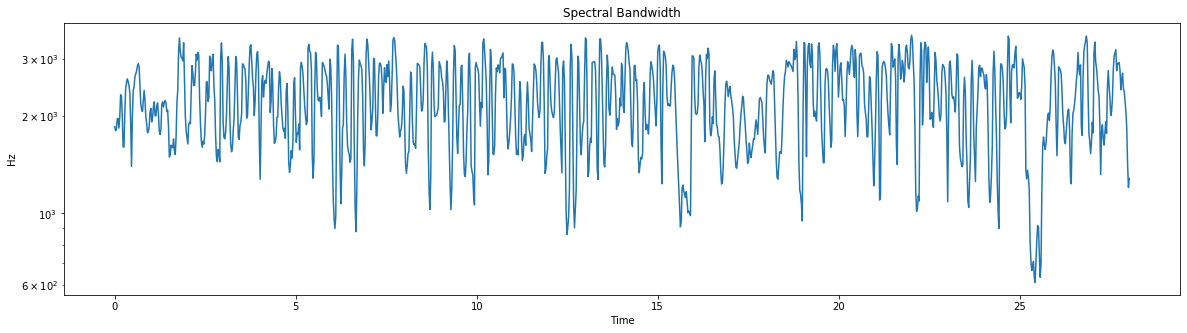

In [18]:
def spectral_bandwidth(audio):
    band = librosa.feature.spectral_bandwidth(y=audio, sr=sr)[0]
    frames = range(len(band))
    t = librosa.frames_to_time(frames)
    
    plt.figure(figsize=(20,5))
    plt.title('Spectral Bandwidth')
    plt.semilogy(t, band.T)
    plt.ylabel('Hz')
    plt.xlabel('Time')

spectral_bandwidth(x)

### Spectral Contrast

It considers the spectral peak and valley in each sub-band separately.
In general, spectral peaks correspond to harmonic components and spectral valleys correspond to non-harmonic components or noise in a music piece.
Therefore, the difference between spectral peaks and spectral valleys will reflect the spectral contrast distribution.

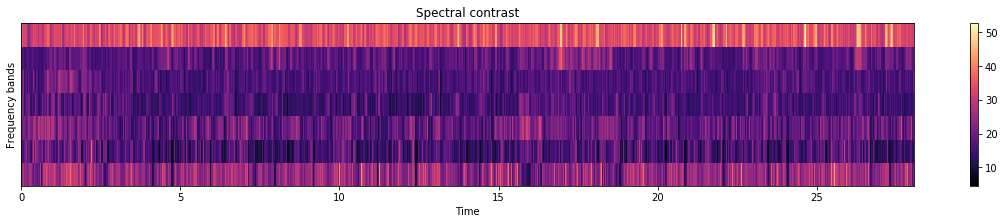

In [10]:
def spectral_contrast(audio):
    S = np.abs(librosa.stft(audio))
    contrast = librosa.feature.spectral_contrast(S=S,sr=sr)
    plt.figure(figsize=(20,3))
    librosa.display.specshow(contrast, x_axis='time')
    plt.colorbar()
    plt.ylabel('Frequency bands')
    plt.title('Spectral contrast')
    
spectral_contrast(x)

### Spectral Rolloff
Spectral rolloff point is defined as the Nth percentile of the power spectral distribution, where N is usually 85% or 95%.
The rolloff point is the frequency below which the N% of the magnitude distribution is concentrated.
This measure is useful in distinguishing voiced speech from unvoiced: unvoiced speech has a high proportion of energy contained in the high-frequency range of the spectrum, where most of the energy for voiced speech and music is contained in lower bands.

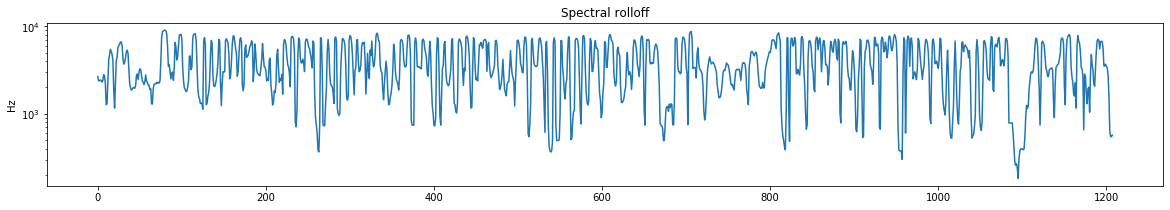

In [11]:
def spectral_rolloff(audio):
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr) 
    plt.figure(figsize=(20,3))
    plt.semilogy(rolloff.T)
    plt.ylabel('Hz')
    plt.title('Spectral rolloff')
    
spectral_rolloff(x)

### Poly features

Get coefficients of fitting an nth-order polynomial to the columns of a spectrogram.

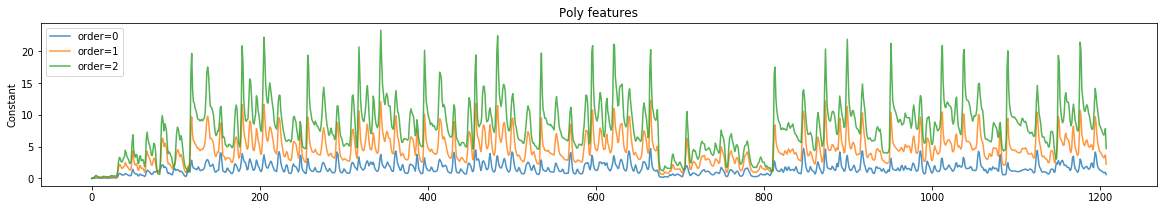

In [12]:
def poly_features(audio):
    S = np.abs(librosa.stft(audio))
    p0 = librosa.feature.poly_features(S=S, order=0)
    p1 = librosa.feature.poly_features(S=S, order=1)
    p2 = librosa.feature.poly_features(S=S, order=2)
    plt.figure(figsize=(20,3))
    plt.plot(p0[0], label='order=0', alpha=0.8)
    plt.plot(p1[1], label='order=1', alpha=0.8)
    plt.plot(p2[2], label='order=2', alpha=0.8)
    plt.title('Poly features')
    plt.ylabel('Constant')
    plt.legend()
    
poly_features(x)

### Tonal Centroid Features

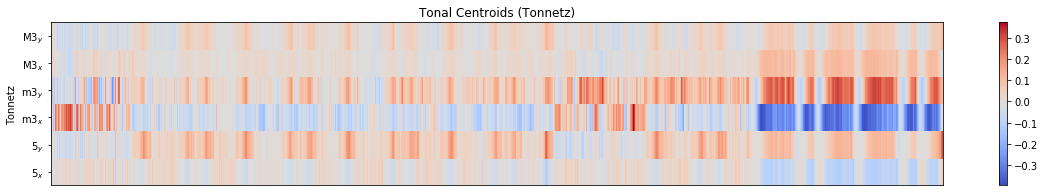

In [13]:
def tonnetz(audio):
    tonnetz = librosa.feature.tonnetz(y=audio, sr=sr)
    plt.figure(figsize=(20,3))
    librosa.display.specshow(tonnetz, y_axis='tonnetz')
    plt.colorbar()
    plt.title('Tonal Centroids (Tonnetz)')

tonnetz(x)

### Zero Crossing Rate

Number of zero-crossings: 21834


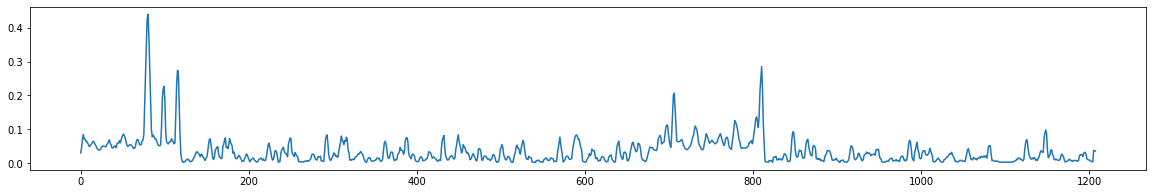

In [14]:
def zcr(audio):
    zero_crossings = librosa.zero_crossings(x, pad=False)
    zcrs = librosa.feature.zero_crossing_rate(x)

    plt.figure(figsize=(20, 3))
    plt.plot(zcrs[0])
    
    return sum(zero_crossings)

print('Number of zero-crossings:', zcr(x))

### Harmonic and Percussive signal separation
harmonic part is what we perceive as pitched sound related to melodies and chords.
percussive part is noise-like and stems from instrument onset like drum kick.
HPSS is Harmonic-Percussive Source Separation.

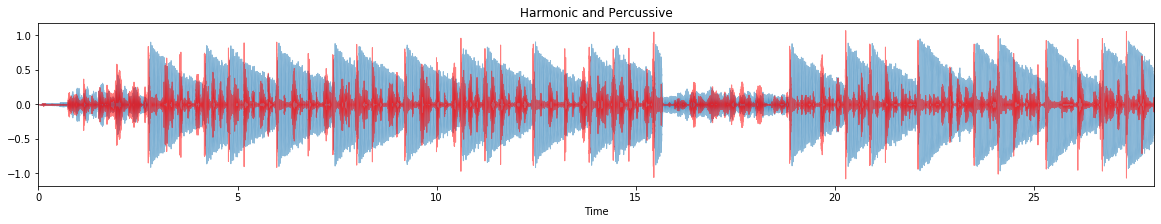

In [15]:
def harmonic_percussive(audio):
    h, p = librosa.effects.hpss(audio)

    plt.figure(figsize=(20, 3))
    librosa.display.waveplot(h, sr=sr, alpha=0.5)
    librosa.display.waveplot(p, sr=sr, color='r', alpha=0.5)
    plt.title('Harmonic and Percussive')
    
harmonic_percussive(x)

In [16]:
# play harmonic signal
h, p = librosa.effects.hpss(x)
ipd.display.Audio(h, rate=sr)

In [17]:
# play percussive signal
h, p = librosa.effects.hpss(x)
ipd.display.Audio(p, rate=sr)

### MFCCs
Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC.
They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum").
The difference between the cepstrum and the mel-frequency cepstrum is that in the MFC, the frequency bands are equally spaced on the mel scale, which approximates the human auditory system's response more closely than the linearly-spaced frequency bands used in the normal cepstrum.

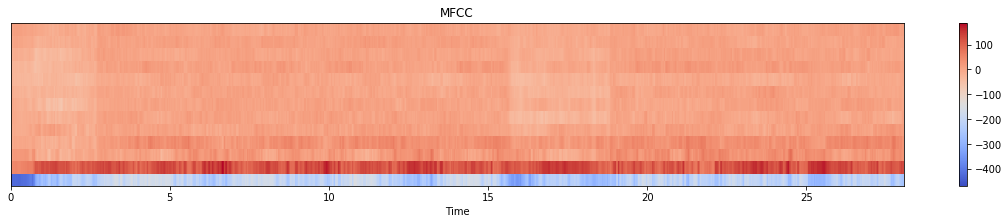

In [18]:
def mfccs(audio, n_mfcc):
    mfccs = librosa.feature.mfcc(y=h, sr=sr, n_mfcc=n_mfcc)
    plt.figure(figsize=(20, 3))
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    
mfccs(x, n_mfcc=13)

### Spectrogram
It is a visual representation of the spectrum of frequencies of a signal as it varies with time.
One axis represents time, and the other axis represents frequency; a third dimension indicating the amplitude of a particular frequency at a particular time is represented by the intensity or color of each point in the image.

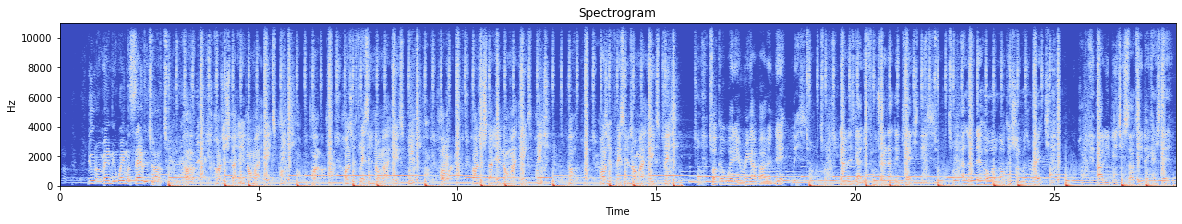

In [19]:
def spectrogram(audio):
    Y = librosa.stft(audio)
    Ydb = librosa.amplitude_to_db(abs(Y))
    plt.figure(figsize=(20, 3))
    librosa.display.specshow(Ydb, sr=sr, x_axis='time', y_axis='hz')
    plt.title('Spectrogram')
    
spectrogram(x)